<a href="https://colab.research.google.com/github/MauriVass/ComplexUpper-LimbMovements/blob/master/Complex_Upper_Limb_Movements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if(os.path.isdir('ComplexUpper-LimbMovements') is False):
  ! git clone https://github.com/MauriVass/ComplexUpper-LimbMovements.git

Cloning into 'ComplexUpper-LimbMovements'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (598/598), done.
remote: Compressing objects: 100% (589/589), done.
remote: Total 598 (delta 32), reused 534 (delta 7), pack-reused 0
Receiving objects: 100% (598/598), 32.54 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

!rm -rf logs

#Set a seed to get repricable results
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

simplified = False
classes = ['BostonCA', 'BostonCU', 'HarvardCA', 'HarvardCU', 'Can', 'Circle', 'Ellipse', 'Flower', 'Spiral', 'SuperMegaCloud', 'Triangle', 'Planned', 'Unplanned', 'Randomness']
classes_simple = ['Boston', 'Harvard', 'Can', 'Circle', 'Ellipse', 'Flower', 'Spiral', 'SuperMegaCloud', 'Triangle', 'Planned', 'Unplanned']

if(simplified):
  classes_lc = [x.lower() for x in classes_simple]
else: classes_lc = [x.lower() for x in classes]

#Read single csv files and save them in a dictinary <action, [array of datasets]>

In [3]:
datasets = {}
for c in classes_lc:
  datasets[c] = []

for dir in os.listdir("ComplexUpper-LimbMovements/Dataset/"):
  subdir = f"ComplexUpper-LimbMovements/Dataset/{dir}/"
  for file in os.listdir(subdir):
    #In the simplified version Randomness and Unplanned classes are merged
    classname = 'unplanned'
    if(simplified):
      for c in classes_lc:
        if(file.lower().find(c)==0):
          classname = c
    else:
      classname = [x for x in classes_lc if file.lower().find(x)==0][0]

    ds = pd.read_csv(subdir+file, sep=';', header=0)
    ds['user'] = [dir] * ds.shape[0]
    ds['action'] = [classname] * ds.shape[0]
    
    order = [4,0,1,2,3,5] # setting column's order
    ds = ds[[ds.columns[i] for i in order]]

    print(classname, subdir+file)
    datasets[classname].append(ds)

circle ComplexUpper-LimbMovements/Dataset/S011/Circle03.csv
harvardca ComplexUpper-LimbMovements/Dataset/S011/Harvardca01.csv
ellipse ComplexUpper-LimbMovements/Dataset/S011/Ellipse90-01.csv
harvardcu ComplexUpper-LimbMovements/Dataset/S011/Harvardcu02.csv
randomness ComplexUpper-LimbMovements/Dataset/S011/Randomness03.csv
planned ComplexUpper-LimbMovements/Dataset/S011/Planned02.csv
ellipse ComplexUpper-LimbMovements/Dataset/S011/Ellipse05.csv
unplanned ComplexUpper-LimbMovements/Dataset/S011/Unplanned01.csv
flower ComplexUpper-LimbMovements/Dataset/S011/Flower02.csv
triangle ComplexUpper-LimbMovements/Dataset/S011/Triangle02.csv
can ComplexUpper-LimbMovements/Dataset/S011/Can03.csv
randomness ComplexUpper-LimbMovements/Dataset/S011/Randomness01.csv
bostonca ComplexUpper-LimbMovements/Dataset/S011/Bostonca02.csv
randomness ComplexUpper-LimbMovements/Dataset/S011/Randomness02.csv
planned ComplexUpper-LimbMovements/Dataset/S011/Planned01.csv
circle ComplexUpper-LimbMovements/Dataset/S01

In [ ]:
datasets['flower'][0]

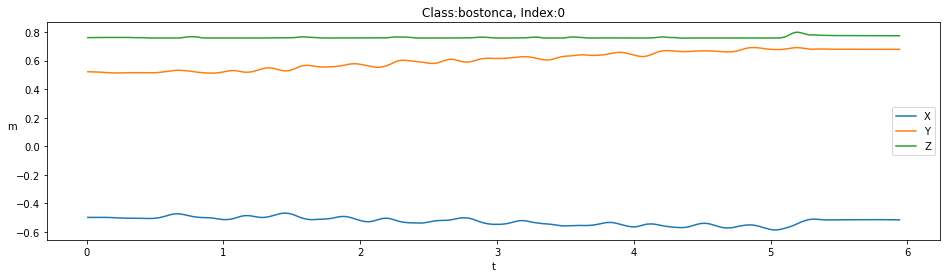

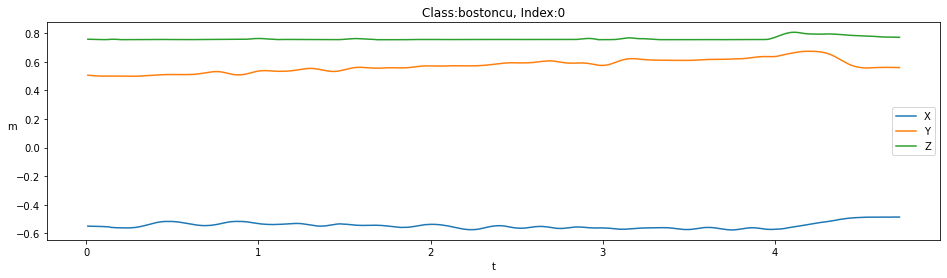

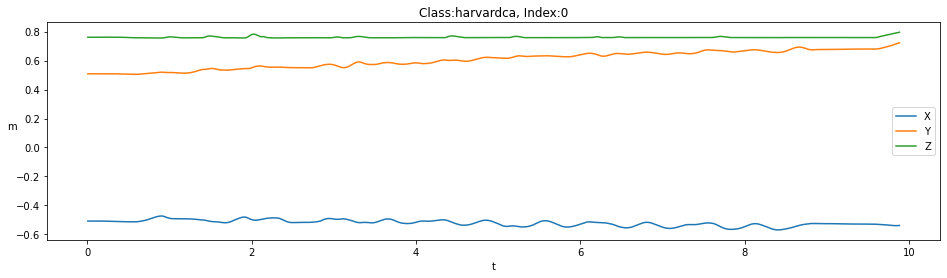

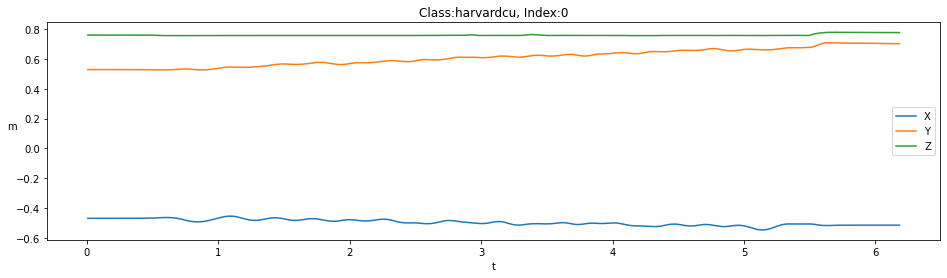

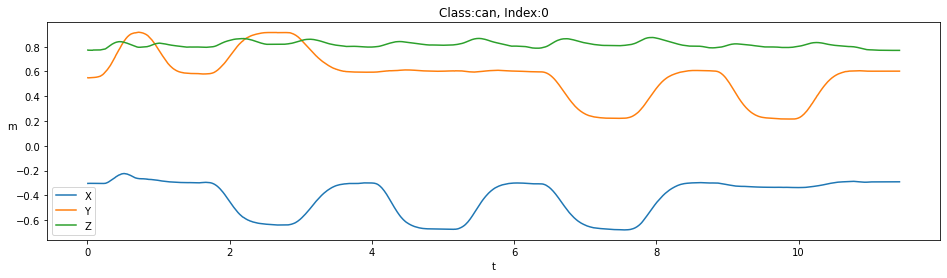

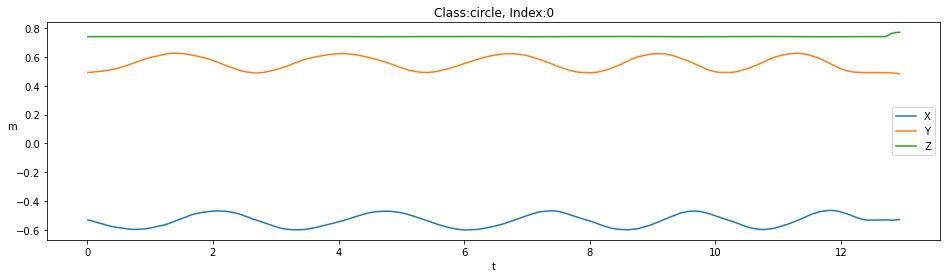

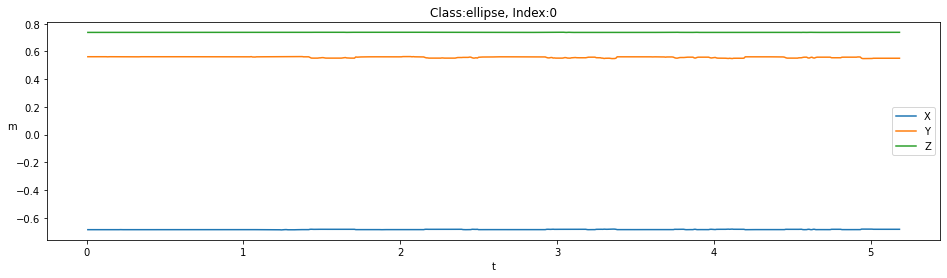

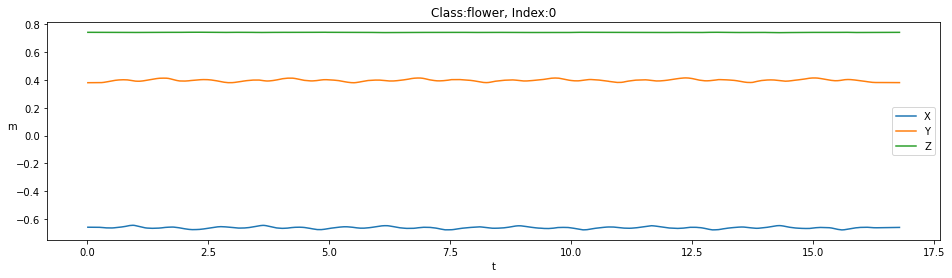

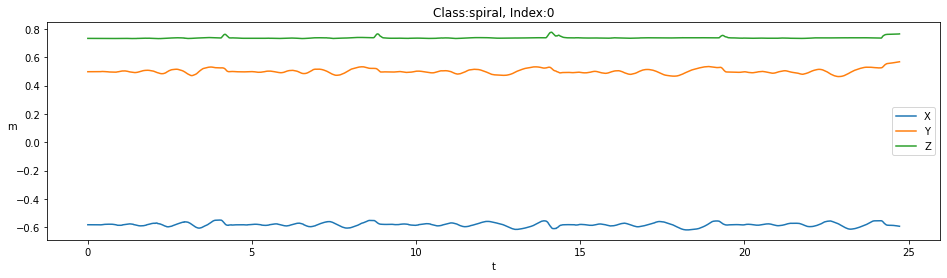

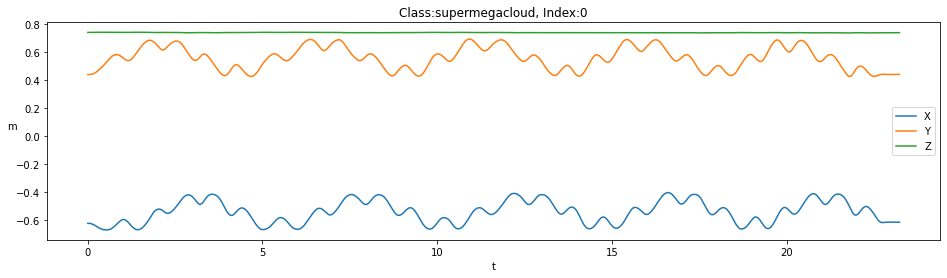

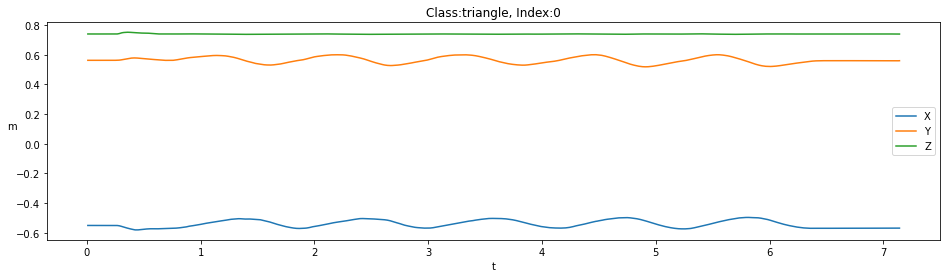

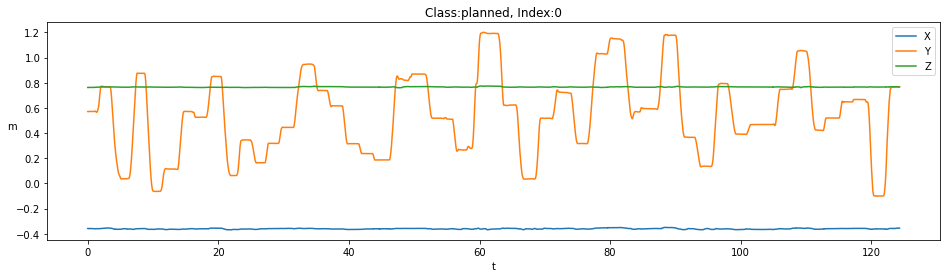

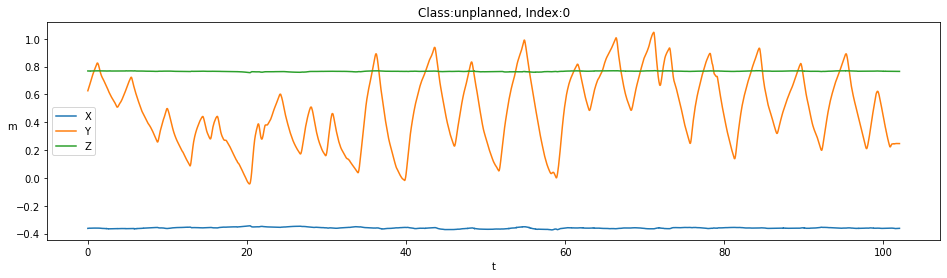

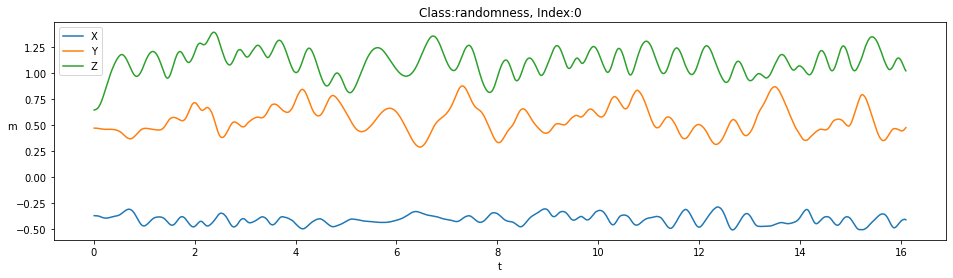

In [7]:
def PlotDataset(classname,index, save=False):
  df = datasets[classname][index]
  title = f'Class:{classname}, Index:{index}'
  ax = df.plot(x="t", y=["X", "Y", "Z"], figsize=(16,4), title=title)
  ax.set_ylabel('m')
  plt.ylabel('m',rotation=0)
  if(save):
    ax.figure.savefig('Images/'+title)

# PlotDataset('randomess', 0)
# PlotDataset('triangle', 0)
if(os.path.isdir('Images') is False):
  os.mkdir('Images')
for c in classes_lc:
  PlotDataset(c, 0, True)

#Single Dataset

##Save Dataset in one csv file
format:
user, t, x, y, z, action

In [4]:
#DO NOT RUN THIS CELL
file = 'ComplexUpper-LimbMovements/dataset.csv'
f = open(file, 'w')
f.write('user,t,X,Y,Z,action\n')
f.close()
for k,v in datasets.items():
  for ds in v:
    ds.to_csv(file,mode='a', index=False, header=False)

##Load Dataset

In [5]:
file = 'ComplexUpper-LimbMovements/dataset.csv'
df = pd.read_csv(file)
df.head(10)

,user,t,X,Y,Z,action
0,S011,0.008333,-0.49856,0.52204,0.76091,bostonca
1,S011,0.016667,-0.49851,0.52194,0.76109,bostonca
2,S011,0.025000,-0.49841,0.52181,0.76123,bostonca
3,S011,0.033333,-0.49842,0.52162,0.76139,bostonca
4,S011,0.041667,-0.49834,0.52148,0.76151,bostonca
5,S011,0.050000,-0.49827,0.52121,0.76167,bostonca
6,S011,0.058333,-0.49826,0.52091,0.76177,bostonca
7,S011,0.066667,-0.49819,0.52057,0.76185,bostonca
8,S011,0.075000,-0.49819,0.52024,0.76190,bostonca
9,S011,0.083333,-0.49812,0.51988,0.76197,bostonca


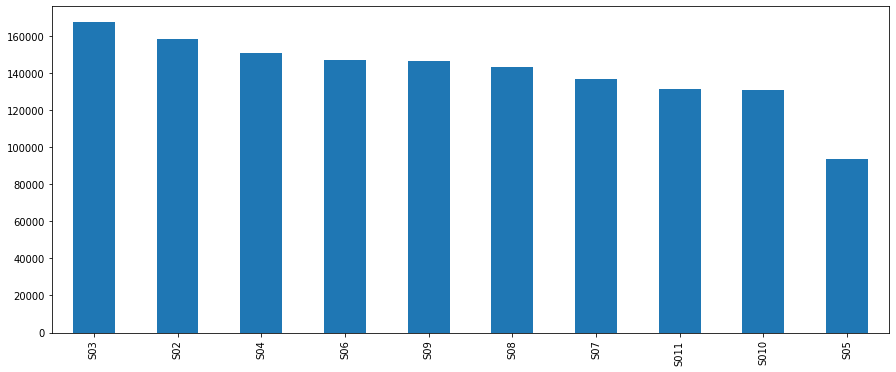

In [6]:
df['user'].value_counts().plot(kind='bar', figsize=(15,6))

Text(0.5, 0, 'Classes')

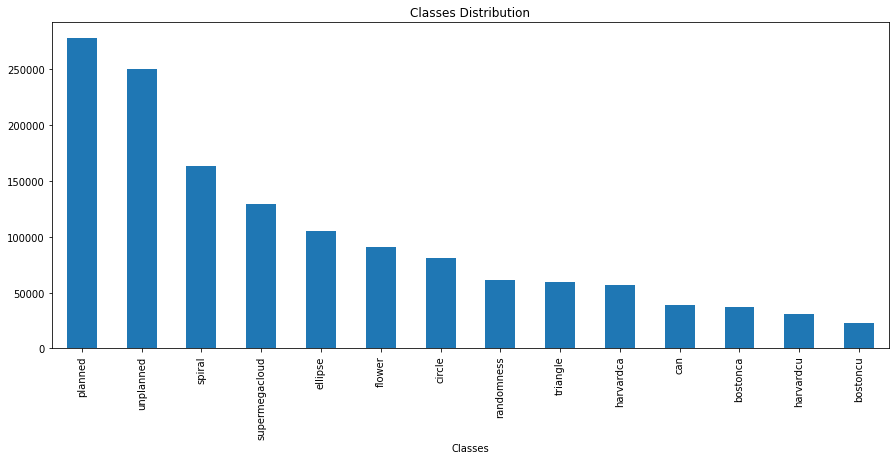

In [10]:
df['action'].value_counts().plot(kind='bar', figsize=(15,6))
plt.title("Classes Distribution")
plt.xlabel("Classes")

In [8]:
df.columns[-1]

'action'

In [ ]:
df_train = df[(df['user'] != 'S010') & (df['user'] != 'S011')]
df_test = df[(df['user'] == 'S010') | (df['user'] == 'S011')]

print(f'Whole dataset:{len(df)}, Train:{len(df_train)}({(len(df_train)/len(df)):.2f}%), {len(df_test)}({(len(df_test)/len(df)):.2f}%)' )

In [ ]:
df_train['action'].value_counts().plot(kind='bar', figsize=(15,6))
df_test['action'].value_counts().plot(kind='bar', figsize=(15,6))

##Scale DataFrames

In [ ]:
from sklearn.preprocessing import RobustScaler
scale_columns = ['X', 'Y', 'Z']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

#Gernerate Windows

In [16]:
from scipy import stats 
def create_dataset(X, y, time_steps=1, step=1, feature_extrac=False):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
      v = X.iloc[i:(i + time_steps)].values
      labels = y.iloc[i: i + time_steps]
      Xs.append(v)
      ys.append(stats.mode(labels)[0][0])
    Xs = np.array(Xs)
    #Preprocess to extract features: mean, std, ...
    if(feature_extrac):
      Xs=preprocess(Xs)
    if(True):
      frame_length, frame_step = 10, 2
      # stft = CalculateSTFT(frame_length, frame_step)
      # Xs = tf.map(stft.get_spectrogram, Xs)
    return Xs, np.array(ys).reshape(-1, 1)

In [17]:
from scipy import signal
from scipy import stats 
import statistics as st
from sklearn import preprocessing

def preprocess(input):
  axis = 1
  mean = np.mean(input, axis=axis)
  median = np.median(input, axis=axis)
  std = np.std(input, axis=axis)
  minv = np.min(input, axis=axis)
  maxv = np.max(input, axis=axis)
  p25 = np.percentile(input, 25, axis=axis)
  p50 = np.percentile(input, 50, axis=axis)
  p75 = np.percentile(input, 75, axis=axis)
  sum = np.sum(input, axis=axis)
  energy = np.sum(np.square(input), axis=axis)
  # fourier_entropy = stats.entropy(input, axis=axis) #may overflow
  skewness = stats.skew(input, axis=axis)
  kurt = stats.kurtosis(input, axis=axis)
  
  result = np.concatenate([mean,median,std,minv,maxv,p25,p50,p75,sum,energy,skewness,kurt],axis=axis)

  # result = preprocessing.normalize(result) #does not work well
  return result

In [14]:
class CalculateSTFT:
  def __init__(self, frame_length, frame_step):
    self.frame_length=frame_length
    self.frame_step=frame_step

  def get_spectrogram(self, signal):
    #Calculate the STFT of the signal given frame_length and frame_step
    spectograms = []
    for i in range(3):
      input = signal[:,i]
      stft = tf.signal.stft(input,
            frame_length=self.frame_length,
            frame_step=self.frame_step,
            fft_length=self.frame_length)
      #Transform the complex number in real number
      spectrogram = tf.abs(stft)
      print()
      spectograms.append(spectrogram)
      spectograms = np.expand_dims(spectograms, axis=0)
      spectograms = tf.convert_to_tensor(spectograms)
      return spectograms

  def preprocess_with_stft(self, input):
    spectrogram = self.get_spectrogram(input)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram  = tf.image.resize(spectrogram, [32,32])
    return spectrogram
stft = CalculateSTFT(frame_length=640, frame_step=320)

In [ ]:
# train_mean = X_train.mean()
# train_std = X_train.std()

# X_train = (train_df - train_mean) / train_std
# X_test = (X_test - train_mean) / train_std
# X_val = (X_val - train_mean) / train_std

In [18]:
train_size = 0.85
val_size = 0.1
#Recording frequency is 120Hz (0.0083 s every sample)
TIME_STEPS = 128
STEP = int(TIME_STEPS * 3 / 4)

use_validation = True

#Total number of entries and flag(total==0)
total = 0
tf_X_train = None
tf_y_train = None
tf_X_test = None
tf_y_test = None
tf_X_val = None
tf_y_val = None
for k,v in datasets.items():
  for ds in v:
    X, y = create_dataset(ds[['X', 'Y', 'Z']], ds.action, TIME_STEPS, STEP, feature_extrac=( not use_validation))
    #Fixed split
    # train_x_tmp = X[:int(len(X)*train_size)]
    # train_y_tmp = y[:int(len(y)*train_size)]
    # test_x_tmp = X[int(len(X)*train_size):]
    # test_y_tmp = y[int(len(y)*train_size):]

    #Split randomly
    index_train = np.random.choice(len(X),int(len(X)*train_size), replace=False)
    index_test = np.delete(np.arange(len(X)),index_train)
    train_x_tmp = X[index_train]
    train_y_tmp = y[index_train]
    test_x_tmp = X[index_test]
    test_y_tmp = y[index_test]

    if(use_validation):
      index_train = np.random.choice(len(train_x_tmp),int(len(train_x_tmp)*(1-val_size)), replace=False)
      index_val = np.delete(np.arange(len(train_x_tmp)),index_train)
      train_x_tmp = X[index_train]
      train_y_tmp = y[index_train]
      val_x_tmp = X[index_val]
      val_y_tmp = y[index_val]

    tf_train_x_tmp = tf.convert_to_tensor(train_x_tmp)
    tf_train_y_tmp = tf.convert_to_tensor(train_y_tmp)
    tf_test_x_tmp = tf.convert_to_tensor(test_x_tmp)
    tf_test_y_tmp = tf.convert_to_tensor(test_y_tmp)
    if(use_validation):
      tf_val_x_tmp = tf.convert_to_tensor(val_x_tmp)
      tf_val_y_tmp = tf.convert_to_tensor(val_y_tmp)

    if(total==0):
      tf_X_train = tf_train_x_tmp
      tf_y_train = tf_train_y_tmp
      tf_X_test = tf_test_x_tmp
      tf_y_test = tf_test_y_tmp
      if(use_validation):
        tf_X_val = tf_val_x_tmp
        tf_y_val = tf_val_y_tmp
    else:
      tf_X_train = tf.concat([tf_X_train,tf_train_x_tmp],0)
      tf_y_train = tf.concat([tf_y_train,tf_train_y_tmp],0)
      tf_X_test = tf.concat([tf_X_test,tf_test_x_tmp],0)
      tf_y_test = tf.concat([tf_y_test,tf_test_y_tmp],0)
      if(use_validation):
        tf_X_val = tf.concat([tf_X_val,tf_val_x_tmp],0)
        tf_y_val = tf.concat([tf_y_val,tf_val_y_tmp],0)
    total+=len(X)

if(use_validation):
  print(f'Train X:{tf_X_train.shape}, Train y:{tf_y_train.shape}, Test X:{tf_X_test.shape}, Test y:{tf_y_test.shape}, Val X:{tf_X_val.shape}, Val y:{tf_y_val.shape}')
  print(f'train/total={(len(tf_X_train)/total):.3f}, test/total={(len(tf_X_test)/total):.3f}, val/train={(len(tf_X_val)/len(tf_X_train)):.3f}')
else:
  print(f'Train X:{tf_X_train.shape}, Train y:{tf_y_train.shape}, Test X:{tf_X_test.shape}, Test y:{tf_y_test.shape}')
  print(f'train/total={(len(tf_X_train)/total):.3f}, test/total={(len(tf_X_test)/total):.3f}')

Train X:(10458, 128, 3), Train y:(10458, 1), Test X:(2376, 128, 3), Test y:(2376, 1), Val X:(1407, 128, 3), Val y:(1407, 1)
train/total=0.734, test/total=0.167, val/train=0.135


In [ ]:
image = tf.transpose(b)
#Add the 'channel' dimension
image = tf.expand_dims(image,-1)
#Take the logarithm for better visualization
image = tf.math.log(image + 1.e-6)

#Normalize to have values on a range [0,255]
min_val = tf.reduce_min(image)
max_val = tf.reduce_max(image)
image = (image-min_val) / (max_val-min_val)
image = image * 255
image = tf.cast(image,tf.uint8)

png_image = tf.io.encode_png(image)
tf.io.write_file(f'imaged.png',png_image)

#One Hot Encoding

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train = tf_X_train
X_test = tf_X_test
if(use_validation):
  X_val = tf_X_val

enc = enc.fit(tf_y_train)
y_train = enc.transform(tf_y_train)
y_test = enc.transform(tf_y_test)
if(use_validation):
  y_val = enc.transform(tf_y_val)

#Models

##Fully Connected Network


In [39]:
modelname = 'Fully Connected Network'
model = keras.Sequential()

model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##LSTM

In [46]:
modelname = 'LSTM'

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Bidirectional LSTM

In [ ]:
#TOO SLOW!
modelname = 'Bidirectional LSTM'
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Conv + LSTM

In [ ]:
modelname = 'Conv + LSTM'

n_steps, n_length = 8, 16
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, n_length, tf_X_train.shape[2])))
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, n_length, tf_X_test.shape[2])))
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, n_length, tf_X_val.shape[2])))

model = keras.Sequential()
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(None,n_length,tf_X_train.shape[-1])))
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Conv LSTM

In [ ]:
modelname = 'Conv LSTM'

n_steps, n_length = 8, 8
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, 1, n_length, tf_X_train.shape[2])), axis=[0])
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, 1, n_length, tf_X_test.shape[2])), axis=[0])
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, 1, n_length, tf_X_val.shape[2])), axis=[0])

# define model
model = keras.Sequential()
model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, tf_X_train.shape[-1])))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

In [47]:
callbacks = []
checkpoint_path = 'KSckp/'
monitor = 'val_acc'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  save_weights_only=True,
  monitor=monitor,
  mode='max',
  save_best_only=True, verbose=0)
callbacks.append(model_checkpoint_callback)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor=monitor, min_delta=0, patience=16, mode='auto',
  baseline=None, restore_best_weights=True, verbose=1)
callbacks.append(early_stopping)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
# callbacks.append(reduce_lr)

tensor_board = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None)
# callbacks.append(tensor_board)


#Train

In [48]:
print(modelname, X_train.shape, X_val.shape)

# opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.9)
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
    X_train, y_train,
    epochs=240,
    initial_epoch=0,
    batch_size=128,
    validation_data=(X_val,y_val),
    shuffle=True,
    callbacks=callbacks
)

LSTM (10458, 128, 3) (1407, 128, 3)
Epoch 1/240
82/82 [==============================] - 26s 290ms/step - loss: 2.3212 - acc: 0.2009 - val_loss: 2.3135 - val_acc: 0.1983
Epoch 2/240
82/82 [==============================] - 23s 286ms/step - loss: 2.1984 - acc: 0.2285 - val_loss: 2.2737 - val_acc: 0.2018
Epoch 3/240
82/82 [==============================] - 23s 286ms/step - loss: 2.1287 - acc: 0.2541 - val_loss: 2.2496 - val_acc: 0.2203
Epoch 4/240
82/82 [==============================] - 24s 287ms/step - loss: 2.0932 - acc: 0.2687 - val_loss: 2.1835 - val_acc: 0.2573
Epoch 5/240
82/82 [==============================] - 24s 287ms/step - loss: 2.0376 - acc: 0.2888 - val_loss: 2.1441 - val_acc: 0.2594
Epoch 6/240
82/82 [==============================] - 23s 286ms/step - loss: 2.1140 - acc: 0.2716 - val_loss: 2.2311 - val_acc: 0.2360
Epoch 7/240
82/82 [==============================] - 24s 287ms/step - loss: 2.0921 - acc: 0.2654 - val_loss: 2.1984 - val_acc: 0.2324
Epoch 8/240
82/82 [=======

In [ ]:
print(X_train[0], y_train[0])
print(X_train[10000], y_train[10000])

In [ ]:
%tensorboard --logdir logs

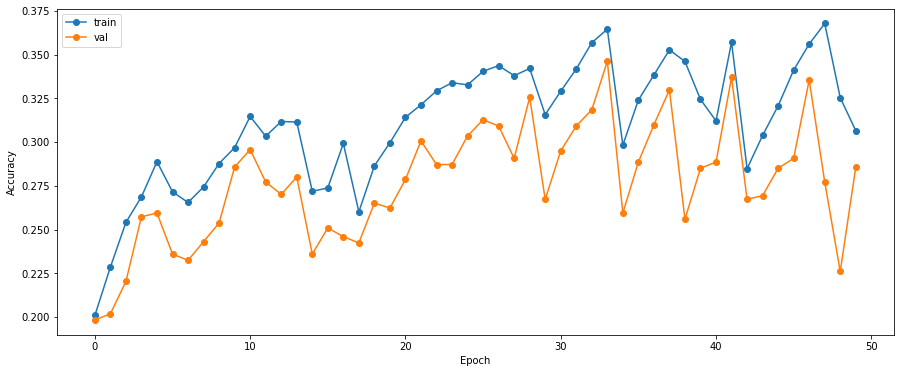

In [49]:
plt.figure(figsize=(15, 6))
start = 0
plt.plot(history.history['acc'][start:], label='train', marker='o')
plt.plot(history.history['val_acc'][start:], label='val', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def metrics(y_test,y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return acc, pre, recall, f1

In [50]:
model.load_weights(checkpoint_path)
X_test = tf.squeeze(X_test)
_, acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_test_ = np.argmax(y_test,axis=1)
y_pred_ = np.argmax(y_pred,axis=1)
acc, pre, recall, f1 = metrics(y_test_,y_pred_)
print(f'Model: {modelname}, Accuracy: {acc:.3f}, Precision": {pre:.3f}, Recall": {recall:.3f}, , F1 score": {f1:.3f}')

75/75 [==============================] - 3s 33ms/step - loss: 1.6982 - acc: 0.3657
Model: LSTM, Accuracy: 0.366, Precision": 0.251, Recall": 0.267, , F1 score": 0.237


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
model.load_weights(checkpoint_path)
_, acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

print(f'Model: {modelname}, Accuracy: {acc:.3f}')
show_metrics(y_test,y_pred)

75/75 [==============================] - 0s 1ms/step - loss: 1.6125 - acc: 0.4150
Model: Fully Connected Network, Accuracy: 0.415


ValueError: ignored

In [ ]:
y_pred

array([[3.16095389e-02, 3.17851789e-02, 8.59410466e-06, ...,
        8.57765377e-02, 1.10049672e-01, 6.00951307e-06],
       [4.42563444e-02, 2.26342231e-02, 3.13820055e-05, ...,
        1.45689458e-01, 7.13831112e-02, 9.81189733e-05],
       [7.73595050e-02, 2.00217292e-02, 5.07393015e-05, ...,
        2.45503902e-01, 2.47471109e-02, 2.11793536e-04],
       ...,
       [7.61880514e-08, 1.94578342e-06, 2.64351871e-02, ...,
        6.46459029e-08, 1.65128526e-07, 4.87459154e-04],
       [1.00834435e-22, 3.05174825e-18, 8.81296322e-02, ...,
        3.43669282e-15, 3.31030600e-17, 8.54753333e-22],
       [1.28947457e-08, 3.25259435e-07, 2.07173016e-05, ...,
        3.75099845e-08, 3.35732153e-07, 3.40786528e-08]], dtype=float32)

#No-Deep Classifiers

##RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfname = 'RandomForestClassifier'
criterion = 'entropy' # criterion{“gini”, “entropy”}, default=”gini”
clf = RandomForestClassifier(n_estimators=2, criterion=criterion, max_depth=None, random_state=0, verbose=1, n_jobs=20)
#Best accuracy with 256 estimators: 0.790

##SVD

In [ ]:
from sklearn.svm import SVC
clfname = 'SVC'
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']# default=’rbf’
degree = 3 #Only 'poly'. default 3
clf = SVC(kernel=kernel[2], degree=degree, gamma='auto', verbose=True)

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())
#Classifier: SVC (kernel=rbf), Accuracy: 0.529

##LinearDiscriminantAnalysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clfname = 'LinearDiscriminantAnalysis'
solver = ['svd',  'lsqr', 'eigen'] #default=’svd’
clf = LinearDiscriminantAnalysis(solver=solver[0])

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())
#LinearDiscriminantAnalysis (svd), Accuracy: 0.396

##QuadraticDiscriminantAnalysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clfname = 'QuadraticDiscriminantAnalysis'
clf = QuadraticDiscriminantAnalysis()

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())
#Classifier: QuadraticDiscriminantAnalysis, Accuracy: 0.468

##AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clfname = 'AdaBoostClassifier'
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())
#Classifier: AdaBoostClassifier (100), Accuracy: 0.327

##GradientBoostingClassifier

In [ ]:
#Slow
from sklearn.ensemble import GradientBoostingClassifier
clfname = 'GradientBoostingClassifier'
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())

##RidgeClassifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
clfname = 'RidgeClassifier'
clf = RidgeClassifier(alpha=10)

y_train = list(tf.squeeze(tf_y_train).numpy())
y_test = list(tf.squeeze(tf_y_test).numpy())
#Classifier: RidgeClassifier, Accuracy: 0.367

##KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clfname = 'KNeighborsClassifier'

k_nei = np.arange(1,10)
# k_nei = np.append( k_nei, np.arange(10,100,5) )

accuracy = []
for k in k_nei:
  clf = KNeighborsClassifier(n_neighbors=k)

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  acc = accuracy_score(y_test, y_pred)
  print(f'k: {k}, Accuracy: {acc:.3f}')
  accuracy.append(acc)

fig = plt.figure()
fig.suptitle('Accuracy Validation Set', fontsize=20)
plt.xlabel(f'k value', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(k_nei,accuracy, marker='o')

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Classifier: {clfname}, Accuracy: {acc:.3f}')

Classifier: RidgeClassifier, Accuracy: 0.373


In [ ]:
# show_metrics(y_test, y_pred)

show_metrics(y_test, y_pred) 

Precision: 0.2495
Recall: 0.2245
F1 Score: 0.2364


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, flag, class_names):
  if(flag==0):
    y_true = [ np.argmax(t) for t in y_true ]
    y_pred = [ np.argmax(t) for t in y_pred ]

  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

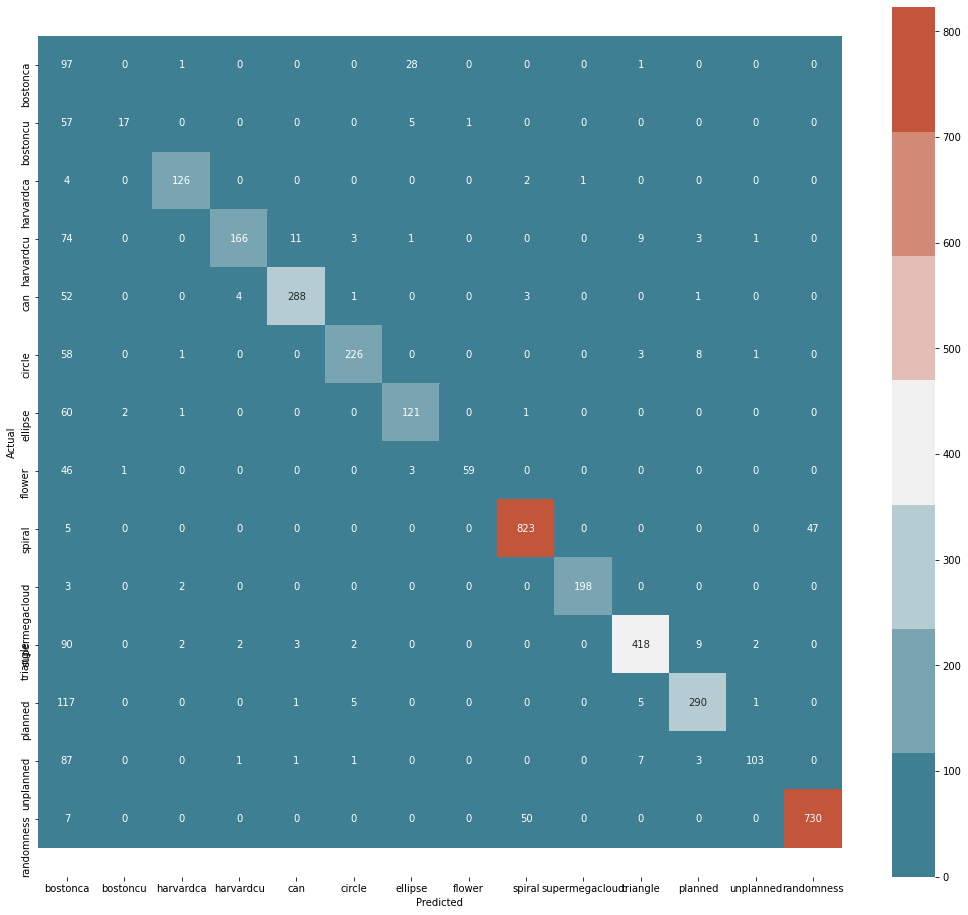

In [ ]:
plot_cm(y_test,y_pred,0,classes_lc)